In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# pmdarima 설치 (Auto-ARIMA 사용을 위해 필요)
!pip install pmdarima

import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ujjwalchowdhury/walmartcleaned")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\KimDongyoung\.cache\kagglehub\datasets\ujjwalchowdhury\walmartcleaned\versions\1


In [3]:
import pandas as pd
import os

# CSV 파일 경로 생성
csv_path = os.path.join(path, "walmart_cleaned.csv")

# 데이터셋 불러오기
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [4]:
# 주 별 매출 집계 테이블 생성

# date 컬럼 날짜형식 변환
df['Date2']= pd.to_datetime(df['Date'])
# 날짜 오름차순 정렬
df = df.sort_values(by='Date2')
# 연도 컬럼 생성
df['Year'] = df['Date2'].dt.year

# 집계 컬럼 함수 설정
def func(df):
    df_sum = {}
    df_sum['Weekly_Sales'] = df['Weekly_Sales'].sum()
    df_sum['Temperature'] = df['Temperature'].mean()
    df_sum['Fuel_Price'] = df['Fuel_Price'].mean()
    df_sum['IsHoliday'] = df['IsHoliday'].max()
    df_sum['CPI'] = df['CPI'].mean()
    df_sum['Unemployment'] = df['Unemployment'].mean()
    return pd.Series(df_sum, index=['Weekly_Sales', 'Temperature',
                                    'Fuel_Price', 'IsHoliday',
                                    'CPI', 'Unemployment'])

# 집계 테이블 생성
df_agg = df.groupby(['Year', 'Date2']).apply(func).reset_index()

df_agg.head()

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_7604\1922248907.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agg = df.groupby(['Year', 'Date2']).apply(func).reset_index()


,Year,Date2,Weekly_Sales,Temperature,Fuel_Price,IsHoliday,CPI,Unemployment
0,2010,2010-02-05,49750740.50,33.277942,2.717869,0.0,167.398405,8.576731
1,2010,2010-02-12,48336677.63,33.361810,2.696102,1.0,167.384138,8.567309
2,2010,2010-02-19,48276993.78,37.038310,2.673666,0.0,167.338966,8.576351
3,2010,2010-02-26,43968571.13,38.629563,2.685642,0.0,167.691019,8.561375
4,2010,2010-03-05,46871470.30,42.373998,2.731816,0.0,167.727351,8.572689


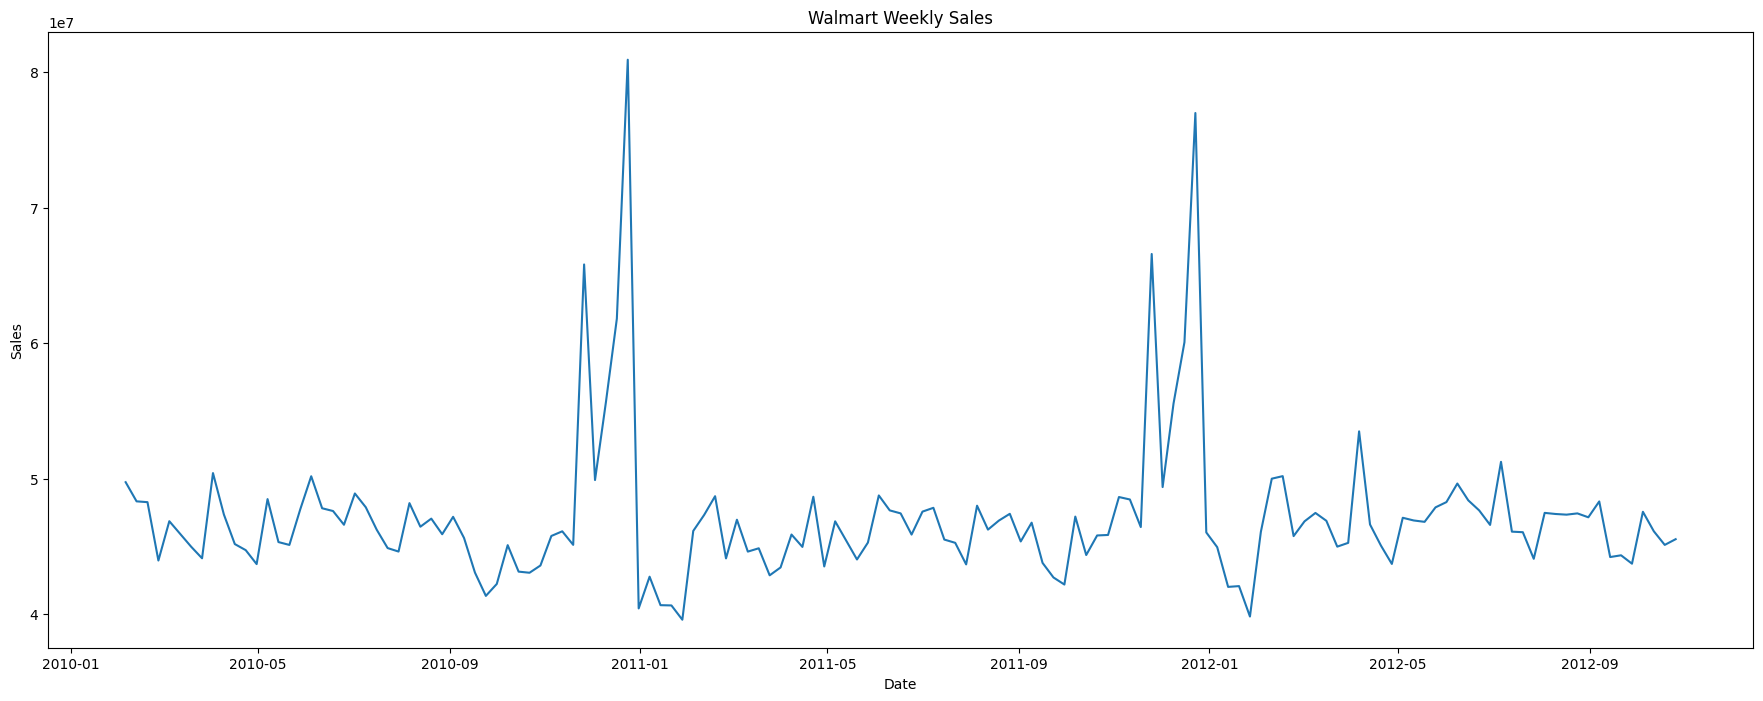

In [5]:
# 전체 매출 추세 확인

plt.figure(figsize=(22,8))
plt.plot(df_agg.Date2,df_agg.Weekly_Sales)
plt.title("Walmart Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [6]:
# 시계열 분해용 데이터셋 생성

timeSeries_decomp = df_agg.loc[:, ["Date2","Weekly_Sales"]]
timeSeries_decomp.index = timeSeries_decomp.Date2
ts_decomp = timeSeries_decomp.drop("Date2",axis=1)

ts_decomp.head()

,Weekly_Sales
Date2,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


<Figure size 640x480 with 0 Axes>

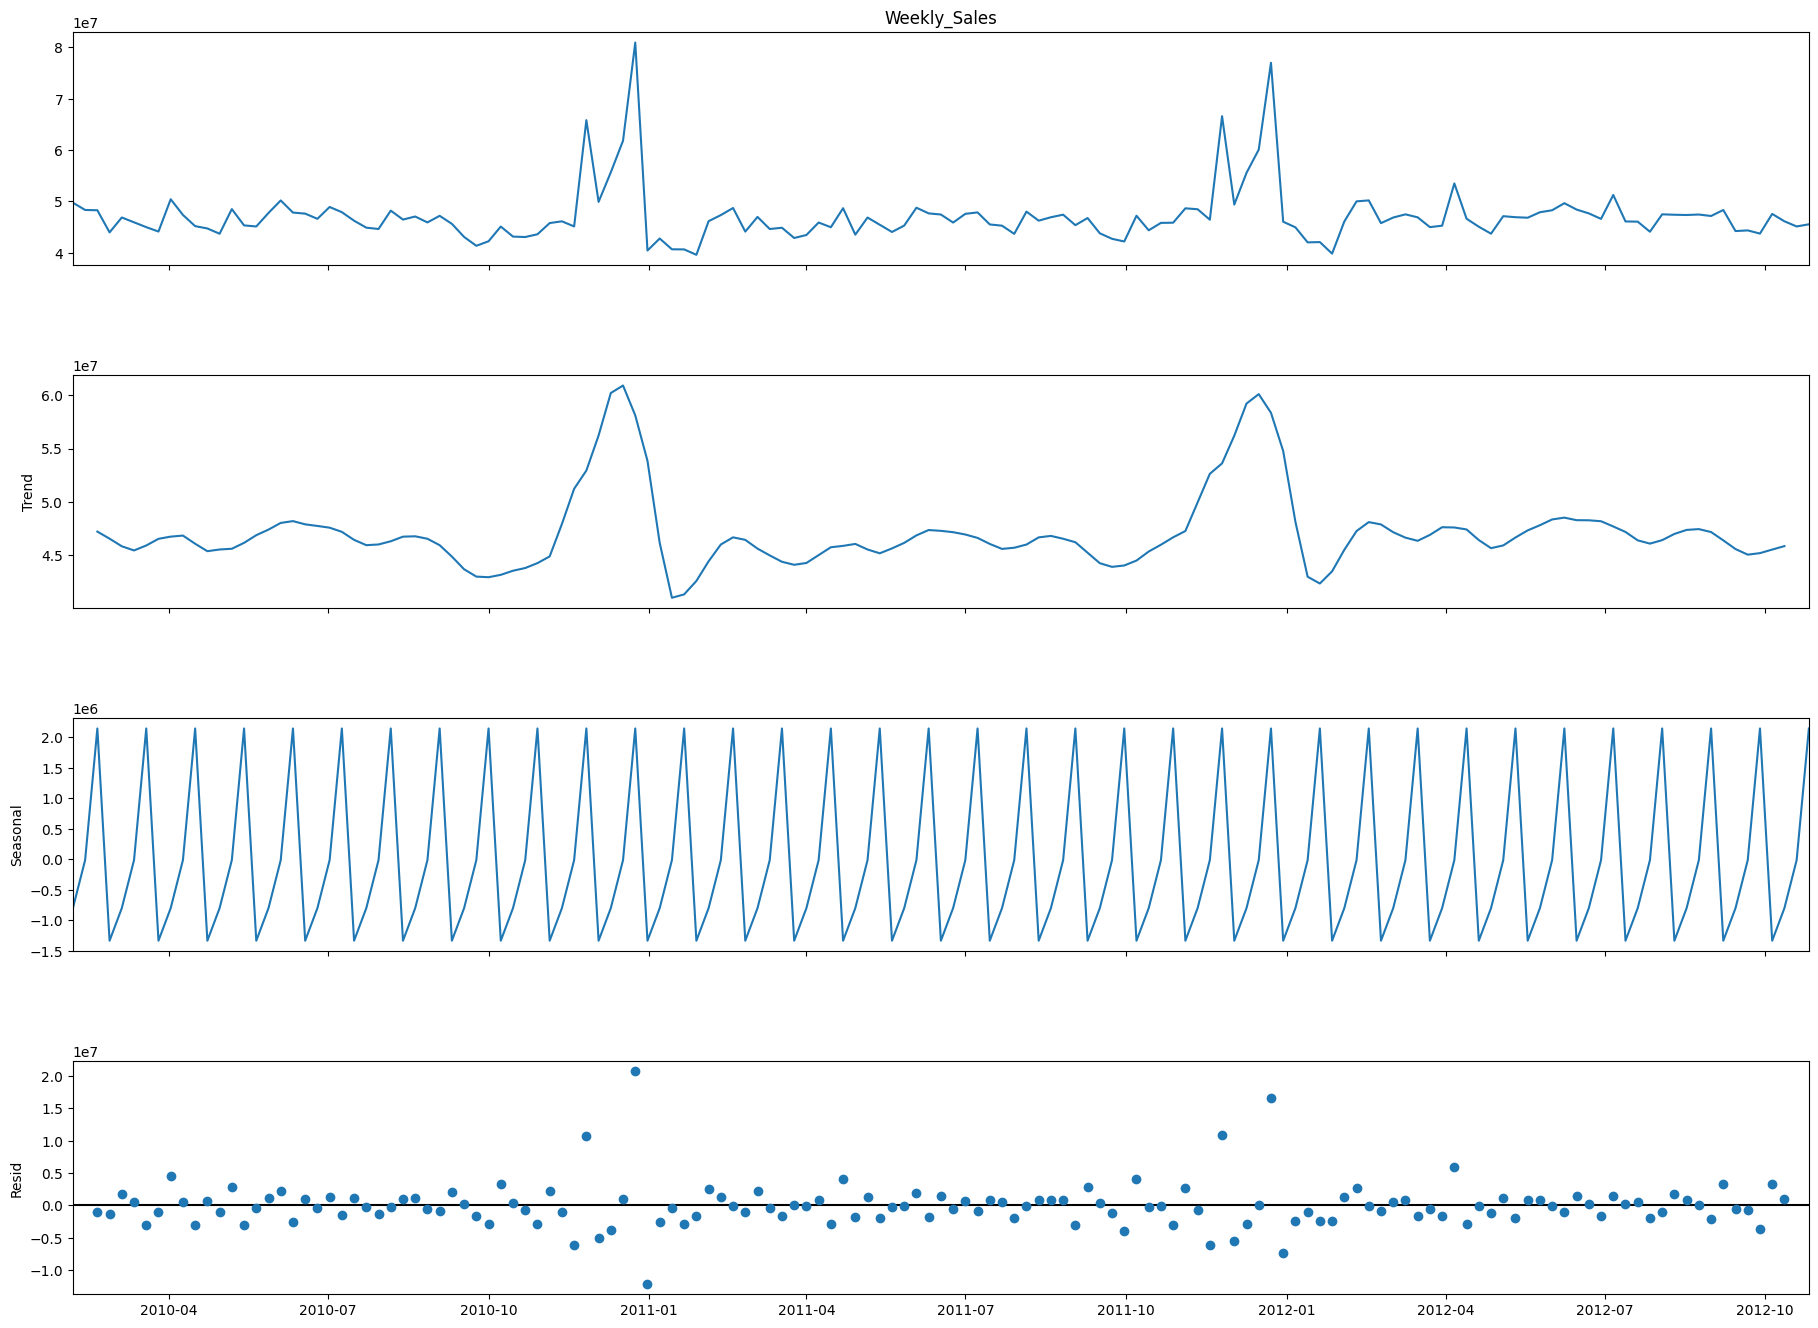

In [7]:
# 시계열 분해 시각화

# period= 월 별은 12, 주 별은 4, 일 별은 7
decomp = seasonal_decompose(ts_decomp['Weekly_Sales'], model='additive', period=4)

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(20, 15)
plt.show()

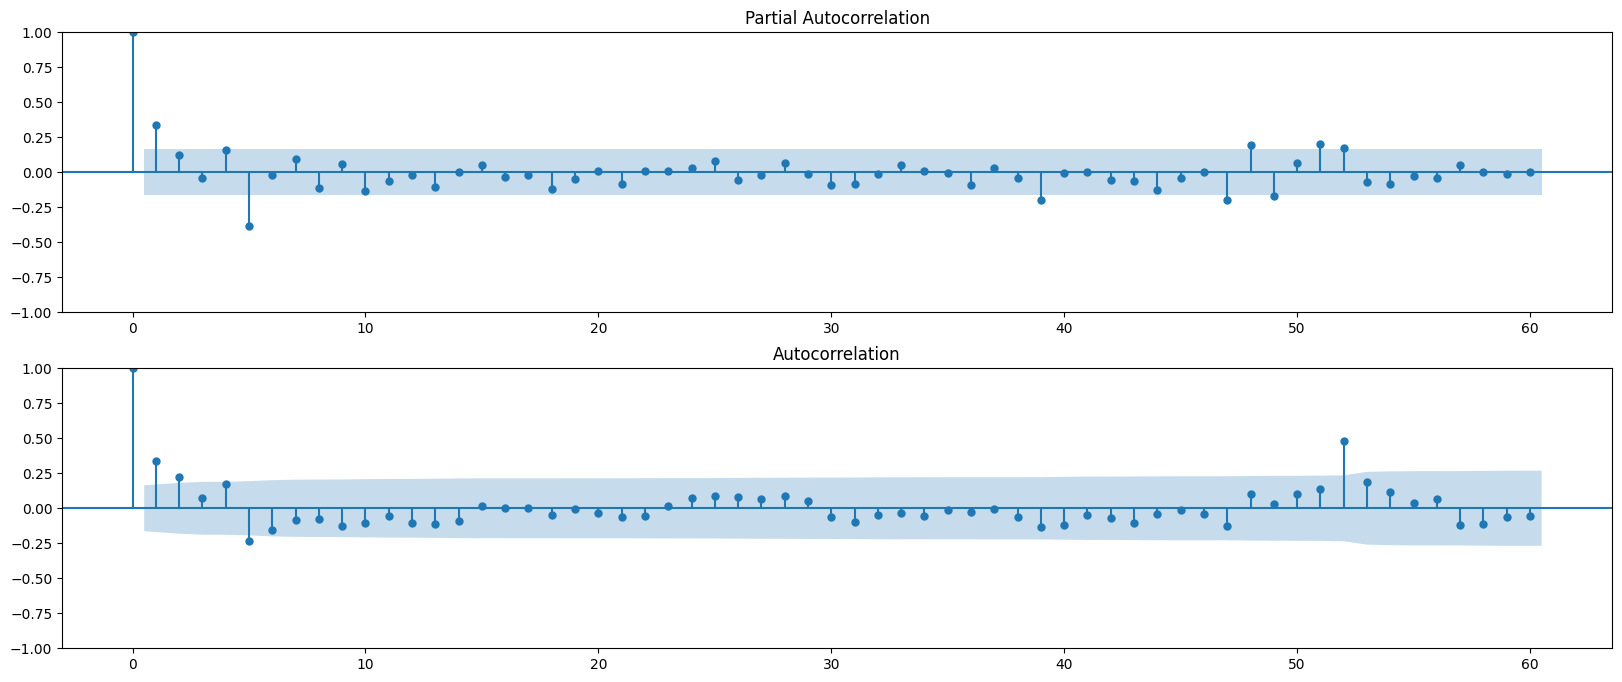

In [8]:
# ACF, PACF 그래프 시각화

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(ts_decomp, lags=60, ax=ax1)

ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(ts_decomp, lags=60, ax=ax2)

In [9]:
# 회귀모델 용 데이터셋 가공

# 1~4, 52주 전 시점 패생변수 생성
df_agg['Weekly_Sales_1w'] = df_agg['Weekly_Sales'].shift(1)
df_agg['Weekly_Sales_2w'] = df_agg['Weekly_Sales'].shift(2)
df_agg['Weekly_Sales_3w'] = df_agg['Weekly_Sales'].shift(3)
df_agg['Weekly_Sales_4w'] = df_agg['Weekly_Sales'].shift(4)
df_agg['Weekly_Sales_52w'] = df_agg['Weekly_Sales'].shift(52)

# 모델용 데이터셋 기간 설정
df_agg_set = df_agg[df_agg["Date2"].isin(pd.date_range('2011-02-05', '2012-10-26'))]

# 독립변수, 종속변수 분리
df_x = df_agg_set.drop(['Year','Date2','Weekly_Sales'],axis=1)
df_y = df_agg_set[['Weekly_Sales']]


# 학습셋과 테스트셋 분리하여 생성(6:4)

x_train, x_test, y_train, y_test = train_test_split(
    df_x,df_y,test_size=0.4,random_state=1)

# 학습셋과 검증셋이 잘 나뉘었는지 확인
print('train data 개수: ', len(x_train))
print('test data 개수: ', len(x_test))

train data 개수:  54
test data 개수:  36


In [10]:
# 다중회귀모델 생성
mreg = LinearRegression(fit_intercept=True)
mreg.fit(x_train, y_train)

# 테스트셋에 모델 적용
y_predict = mreg.predict(x_test)

# 모델 성능 확인
print("학습셋 R-Square: {:.5f}".format(mreg.score(x_train, y_train)))
print("테스트셋 R-Square: {:.5f}".format(mreg.score(x_test, y_test)))

학습셋 R-Square: 0.82340
테스트셋 R-Square: 0.89378


In [11]:
# 모델 상세 확인

ols_m = sm.OLS(y_train, sm.add_constant(x_train)).fit()
ols_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     20.05
Date:                Tue, 27 May 2025   Prob (F-statistic):           4.25e-13
Time:                        21:38:15   Log-Likelihood:                -829.81
No. Observations:                  54   AIC:                             1682.
Df Residuals:                      43   BIC:                             1704.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.736e+08   1.06e+08     -1.645      0.107   -3.86e+08    3.92e+07
Temperature       1.128e+04   1.42e+04      0.794      0.432   -1.74e+04    3.99e+04
Fuel_Price       -1.471e+06   1.11e+06     -1.320      0.194   -3.72e+06    7.76e+05
IsHoliday         8.763e+05   7.81e+05      1.122      0.268   -6.99e+05    2.45e+06
CPI               9.353e+05   5.08e+05      1.839      0.073   -9.01e+04    1.96e+06
Unemployment      3.305e+06   2.68e+06      1.234      0.224    -2.1e+06    8.71e+06
Weekly_Sales_1w      0.0750      0.056      1.347      0.185      -0.037       0.187
Weekly_Sales_2w      0.0470      0.043      1.099      0.278      -0.039       0.133
Weekly_Sales_3w      0.0079      0.044      0.180      0.858      -0.080       0.096
Weekly_Sales_4w     -0.0590      0.075     -0.784      0.437      -0.211       0.093
Weekly_Sales_52w     0.7359      0.066     11.169      0.000       0.603       0.869
==============================================================================
Omnibus:                       13.772   Durbin-Watson:                   2.366
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.759
Skew:                          -0.769   Prob(JB):                     1.14e-05
Kurtosis:                       5.784   Cond. No.                     6.35e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.35e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# ADF 검정

# p-value가 0.05 미만이므로 대립가설채택. 즉, 정상성 만족.
def ADF(ts_decomp):
    result = adfuller(ts_decomp.values, autolag="AIC")
    print("------ Augmented Dickey-Fuller Test ------")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF(ts_decomp)

------ Augmented Dickey-Fuller Test ------
ADF Statistic: -5.908298
p-value: 0.0000002676
Lag: 4
observation: 138
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [13]:
# ARIMA용 학습셋, 테스트셋 생성

train= ts_decomp.loc['2010-02-05':'2012-09-21']
test= ts_decomp.loc['2012-09-28':'2012-10-26']

# 학습셋과 검증셋이 잘 나뉘었는지 확인
print('train data 개수: ', len(train))
print('test data 개수: ', len(test))

train data 개수:  138
test data 개수:  5


In [14]:
# ARIMA 예측값 출력

# p,d,q 파라미터값 설정
p, d, q = 3, 0, 3

model_arima = ARIMA(train["Weekly_Sales"], order=(p,d,q))
model_arima_fit = model_arima.fit()

# 예측값 출력
pred1 = model_arima_fit.forecast(steps=5)[0]
pred1 = pd.Series(pred1, index=test.index)

print(np.round_(pred1,2))

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_7604\2398368957.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Date2
2012-09-28    46275797.08
2012-10-05    46275797.08
2012-10-12    46275797.08
2012-10-19    46275797.08
2012-10-26    46275797.08
dtype: float64


<Axes: xlabel='Date2', ylabel='Weekly_Sales'>

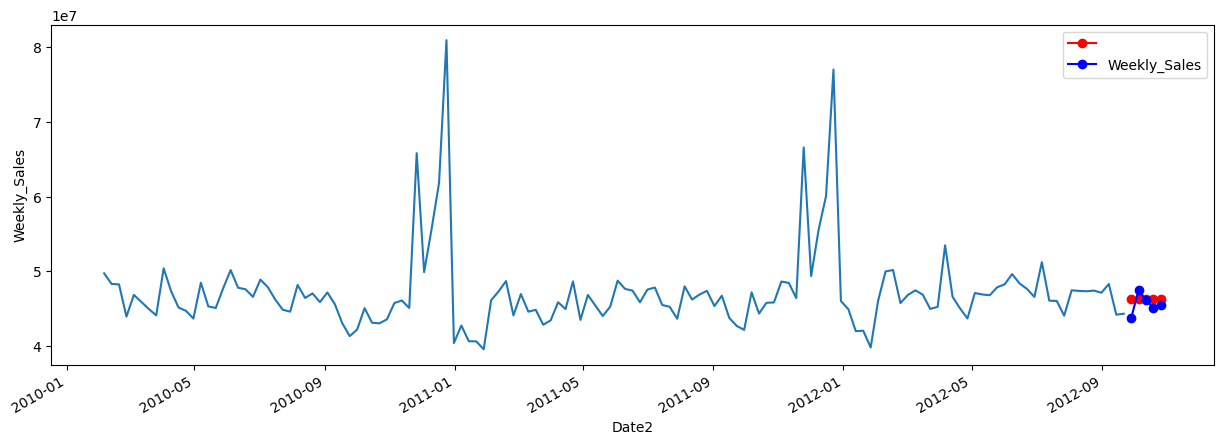

In [15]:
# ARIMA 모델 예측값 시각화

fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x='Date2', y='Weekly_Sales', data = train)
pred1.plot(ax=ax, color='red', marker="o", legend=True)
test.plot(ax=ax, color='blue', marker="o", legend=True)

<Axes: xlabel='Date2', ylabel='Weekly_Sales'>

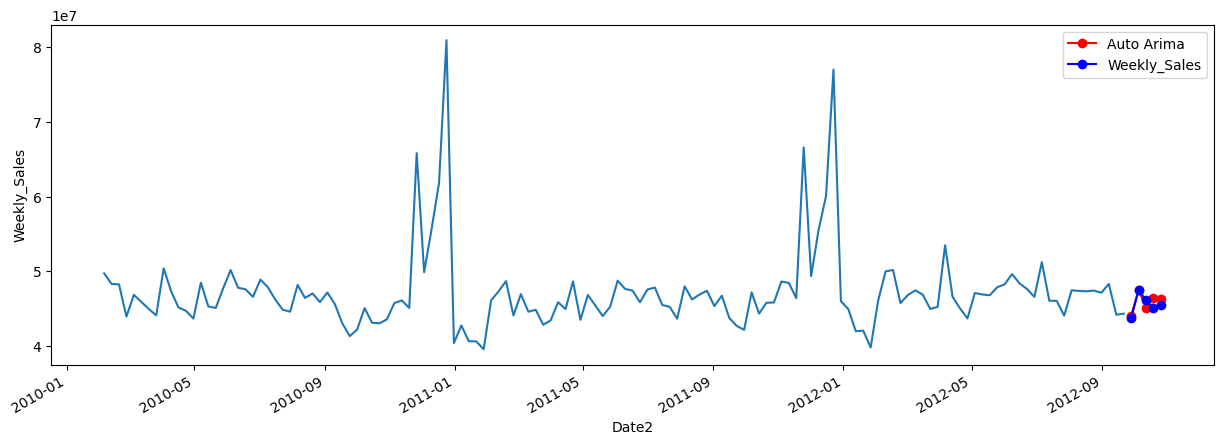

In [16]:
# Auto-ARIMA 모델 예측값 시각화

auto_arima_model = pm.auto_arima(train, seasonal=True, m=52)

# 모델 예측
pred2 = auto_arima_model.predict(5)
pred2 = pd.Series(pred2, index=test.index)
pred2 = pred2.rename("Auto Arima")

# 예측값 시각화
fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x='Date2', y='Weekly_Sales', data = train)
pred2.plot(ax=ax, color='red', marker="o", legend=True)
test.plot(ax=ax, color='blue', marker="o", legend=True)

# Auto-ARIMA 돌리기 - 계측값이 일별이면 m=7, 월별이면 m=12, 주별이면 m=52,
# 계절성이 있는 데이터면 seasonal=True 로 바꿔야함. 알아서 d 값을 찾아줌.

In [17]:
# Auto-ARIMA 모델 요약

print(auto_arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  138
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2296.614
Date:                             Tue, 27 May 2025   AIC                           4607.228
Time:                                     21:40:23   BIC                           4627.719
Sample:                                 02-05-2010   HQIC                          4615.555
                                      - 09-21-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.115e+07    1.7e-08   1.83e+15      0.000    3.12e+07    3.12e+07
ar.L1         -0.8130      

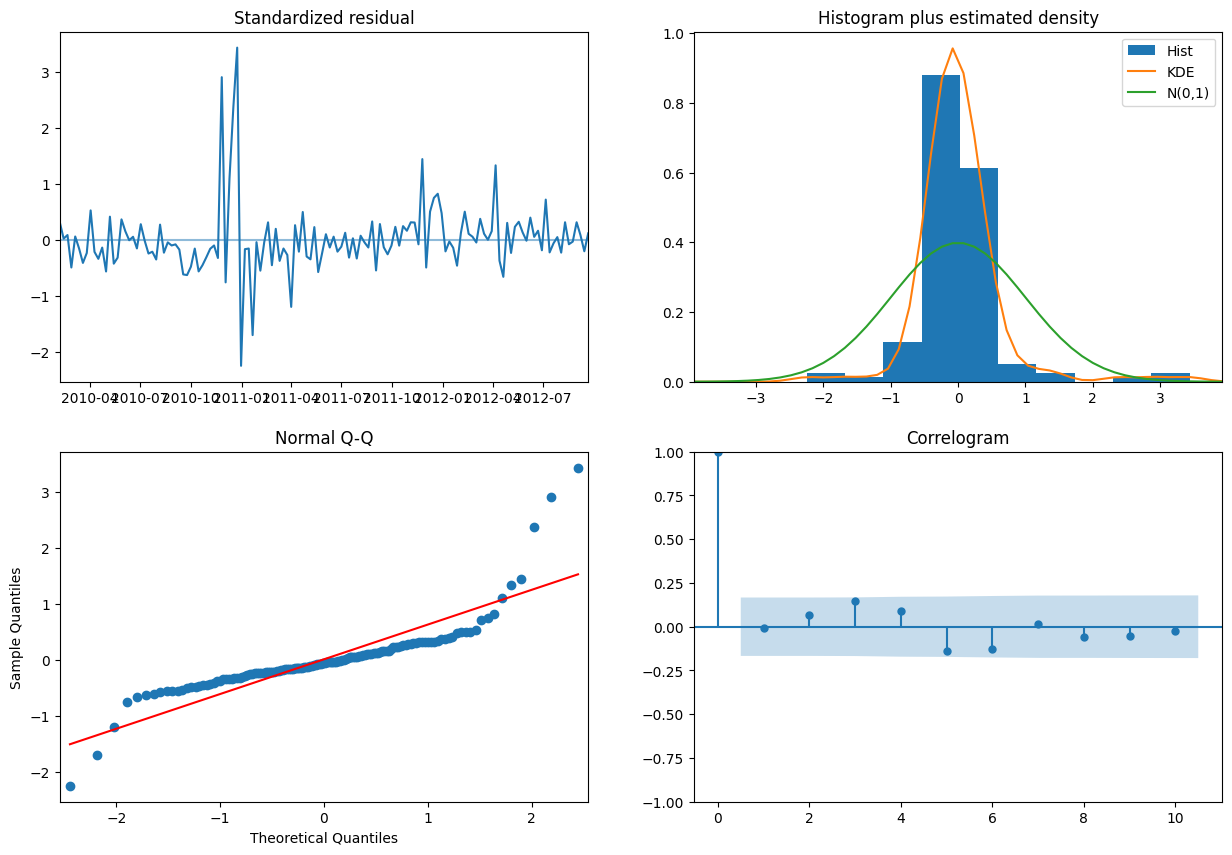

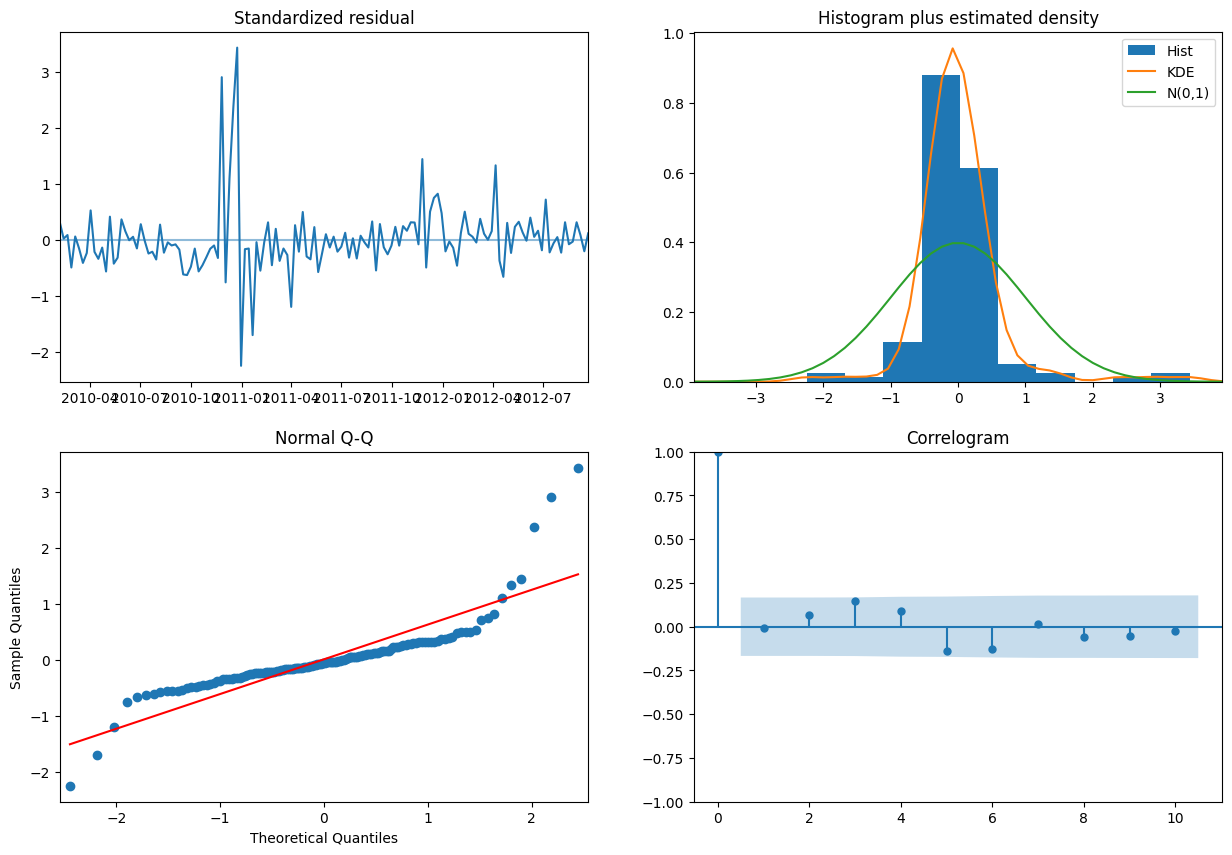

In [18]:
# 모델 적합성 시각화

auto_arima_model.plot_diagnostics(figsize=(15,10))